In [27]:
import numpy as np
#if this fails, you need to put the case_studies.py file in the same folder
from case_studies import *

In [28]:
from scipy.optimize import minimize

#These are the example optimizers you should evaluate this week.
#These ar eoptimizers implemented in scipy.
#they take as first 2 or 3 arguments the function f, its gradient df and sometimes its hessian Hf.
#the next parameters are all the same: x0 is the starting point, max_iterations the stopping criterion for iterations
#and epsilon the precision tolerance to be reached. 
#Note: epsilon is interpreted slightly differently across algorithms, and some algorithms might not reach the tolerance
#and stop early.
def scipy_bfgs(f,df,x0,max_iterations,epsilon):
    xs=[]
    grad_norms=[]
    def logging_f(x):
        xs.append(x)
        grad_norms.append(np.maximum(np.linalg.norm(df(x)),10**(-5)*epsilon))
        return f(x)
    minimize(logging_f, x0, method="BFGS", jac=df, tol=epsilon,options={'maxiter':max_iterations, 'gtol':epsilon})
    return np.array(xs), np.array(grad_norms)

def scipy_newton(f,df,Hf,x0,max_iterations,epsilon):
    xs=[]
    grad_norms=[]
    def logging_f(x):
        xs.append(x)
        grad_norms.append(np.maximum(np.linalg.norm(df(x)),10**(-5)*epsilon))
        return f(x)
    minimize(logging_f, x0, method="Newton-CG", jac=df, hess=Hf, tol=epsilon,options={'maxiter':max_iterations,'xtol':epsilon})
    return np.array(xs), np.array(grad_norms)

def scipy_trust_region(f,df,Hf,x0,max_iterations,epsilon):
    xs=[]
    grad_norms=[]
    def logging_f(x):
        xs.append(x)
        grad_norms.append(np.maximum(np.linalg.norm(df(x)),10**(-5)*epsilon))
        return f(x)
    minimize(logging_f, x0, method="trust-exact", jac=df, hess=Hf, tol=epsilon,options={'maxiter':max_iterations})
    return np.array(xs), np.array(grad_norms)

In [29]:
#example usage of the algorithms
#the output is a list of points evaluated on the function as well as the gradient norms at that point
#this algorithms has the first three arguments functions for function value, gradient and Hessian.
#For the 5 functions, those are named f1-f5 etc and cna be found in the case_studies.py file
x0=np.ones(2)
xs,grad_norms = scipy_trust_region(f4,df4,Hf4,x0, 1000, 1.e-10)


#the optimal point for a given function and dimensionality is stored in the package as well for at least 15 decimals precision
optimal = x_opt("f4", 2)
print("final solution point:", xs[-1])
print("distance of x from optimum", np.linalg.norm(xs[-1]-optimal))
print("number of function evaluations:", len(grad_norms))
print("final function value:", f4(xs[-1]))
print("final gradient norm:", grad_norms[-1])


final solution point: [0.00190933 0.00190933]
distance of x from optimum 1.1857524696459338e-11
number of function evaluations: 9
final function value: 1.2203194789920598e-05
final gradient norm: 9.977761920841575e-11


# Testing Protocol for Optimization Algorithm Comparison

We implement a comprehensive testing protocol to compare the three optimization algorithms (BFGS, Newton-CG, Trust Region) on functions f1-f5.

## Methodology:
- Sample 100 initial points from multivariate Gaussian N(x*, 100·I) centered at each function's optimum
- Run each optimizer with tolerance ε=1e-6 and max 1000 iterations
- Track f(x_j) - f(x*) and |x_j - x*| at each iteration
- Select min, max, and median convergence runs for visualization

In [30]:
import matplotlib.pyplot as plt
import time
from collections import defaultdict

def generate_initial_points(x_optimal, n_points=100, variance=100, seed=42):
    """Generate initial points from N(x*, variance·I)"""
    np.random.seed(seed)
    dim = len(x_optimal)
    cov = variance * np.eye(dim)
    return np.random.multivariate_normal(x_optimal, cov, size=n_points)

def run_optimizer_with_tracking(optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon):
    """Run optimizer and track convergence metrics"""
    start_time = time.time()
    
    if optimizer == scipy_bfgs:
        xs, grad_norms = optimizer(f, df, x0, max_iter, epsilon)
    else:
        xs, grad_norms = optimizer(f, df, Hf, x0, max_iter, epsilon)
    
    elapsed_time = time.time() - start_time
    
    f_errors = np.array([f(x) - f_opt_val for x in xs])
    x_errors = np.array([np.linalg.norm(x - x_opt_val) for x in xs])
    
    return {
        'iterations': len(xs),
        'time': elapsed_time,
        'f_errors': f_errors,
        'x_errors': x_errors,
        'grad_norms': grad_norms
    }

def run_testing_protocol(function_suite, optimizers, n_initial_points=100, max_iter=1000, epsilon=1e-6):
    """Run complete testing protocol"""
    results = defaultdict(lambda: defaultdict(list))
    
    for func_name, f, df, Hf, dim in function_suite:
        x_opt_val = x_opt(func_name, dim)
        f_opt_val = f(x_opt_val)
        initial_points = generate_initial_points(x_opt_val, n_initial_points)
        
        for opt_name, optimizer in optimizers:
            for x0 in initial_points:
                try:
                    result = run_optimizer_with_tracking(
                        optimizer, f, df, Hf, x0, x_opt_val, f_opt_val, max_iter, epsilon
                    )
                    results[func_name][opt_name].append(result)
                except:
                    continue
    
    return results

def select_representative_runs(run_results, metric='iterations'):
    """Select min, max, and median runs based on specified metric"""
    metrics = np.array([r[metric] for r in run_results])
    
    min_idx = np.argmin(metrics)
    max_idx = np.argmax(metrics)
    median_idx = np.argsort(metrics)[len(metrics) // 2]
    
    return {
        'min': run_results[min_idx],
        'max': run_results[max_idx],
        'median': run_results[median_idx]
    }

In [31]:
def plot_convergence_comparison(results, function_suite):
    """Create convergence plots: steps (left) and time (right) for each function"""
    n_funcs = len(function_suite)
    fig, axes = plt.subplots(n_funcs, 2, figsize=(14, 3.5*n_funcs))
    if n_funcs == 1:
        axes = axes.reshape(1, -1)
    
    opt_colors = {'BFGS': 'red', 'Newton-CG': 'green', 'Trust-Region': 'blue'}
    
    for idx, (func_name, _, _, _, _) in enumerate(function_suite):
        ax_steps = axes[idx, 0]
        ax_time = axes[idx, 1]
        
        for opt_name in ['BFGS', 'Newton-CG', 'Trust-Region']:
            run_results = results[func_name][opt_name]
            if not run_results:
                continue
            
            color = opt_colors[opt_name]
            repr_runs_iter = select_representative_runs(run_results, metric='iterations')
            repr_runs_time = select_representative_runs(run_results, metric='time')
            
            # Plot steps
            for run_data in repr_runs_iter.values():
                errors = np.abs(run_data['f_errors']) + 1e-20
                steps = np.arange(len(errors))
                ax_steps.semilogy(steps, errors, color=color, alpha=0.8, linewidth=1.5)
            
            # Plot time
            for run_data in repr_runs_time.values():
                errors = np.abs(run_data['f_errors']) + 1e-20
                times = np.linspace(0, run_data['time'], len(errors))
                ax_time.semilogy(times, errors, color=color, alpha=0.8, linewidth=1.5)
        
        # Format plots
        ax_steps.set_xlabel('steps', fontsize=10)
        ax_steps.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
        ax_steps.set_title(f'steps to reach tolerance on {func_name}', fontsize=11)
        ax_steps.grid(True, alpha=0.3, linewidth=0.5)
        
        ax_time.set_xlabel('time (s)', fontsize=10)
        ax_time.set_ylabel(r'$|f(x_j) - f(x^*)|$', fontsize=10)
        ax_time.set_title(f'time to reach tolerance on {func_name}', fontsize=11)
        ax_time.grid(True, alpha=0.3, linewidth=0.5)
        
        # Legend on right plots only
        legend_elements = [
            plt.Line2D([0], [0], color='red', linewidth=2, label='bfgs'),
            plt.Line2D([0], [0], color='green', linewidth=2, label='newton'),
            plt.Line2D([0], [0], color='blue', linewidth=2, label='trust region')
        ]
        ax_time.legend(handles=legend_elements, loc='best', fontsize=9, framealpha=0.9)
    
    plt.tight_layout()
    return fig

In [32]:
# Define test suite and run protocol
function_suite = [
    ("f1", f1, df1, Hf1, 2),
    ("f2", f2, df2, Hf2, 2),
    ("f3", f3, df3, Hf3, 2),
    ("f4", f4, df4, Hf4, 2),
    ("f5", f5, df5, Hf5, 2)
]

optimizers = [
    ("BFGS", scipy_bfgs),
    ("Newton-CG", scipy_newton),
    ("Trust-Region", scipy_trust_region)
]

results = run_testing_protocol(function_suite, optimizers, n_initial_points=100, 
                               max_iter=1000, epsilon=1e-6)

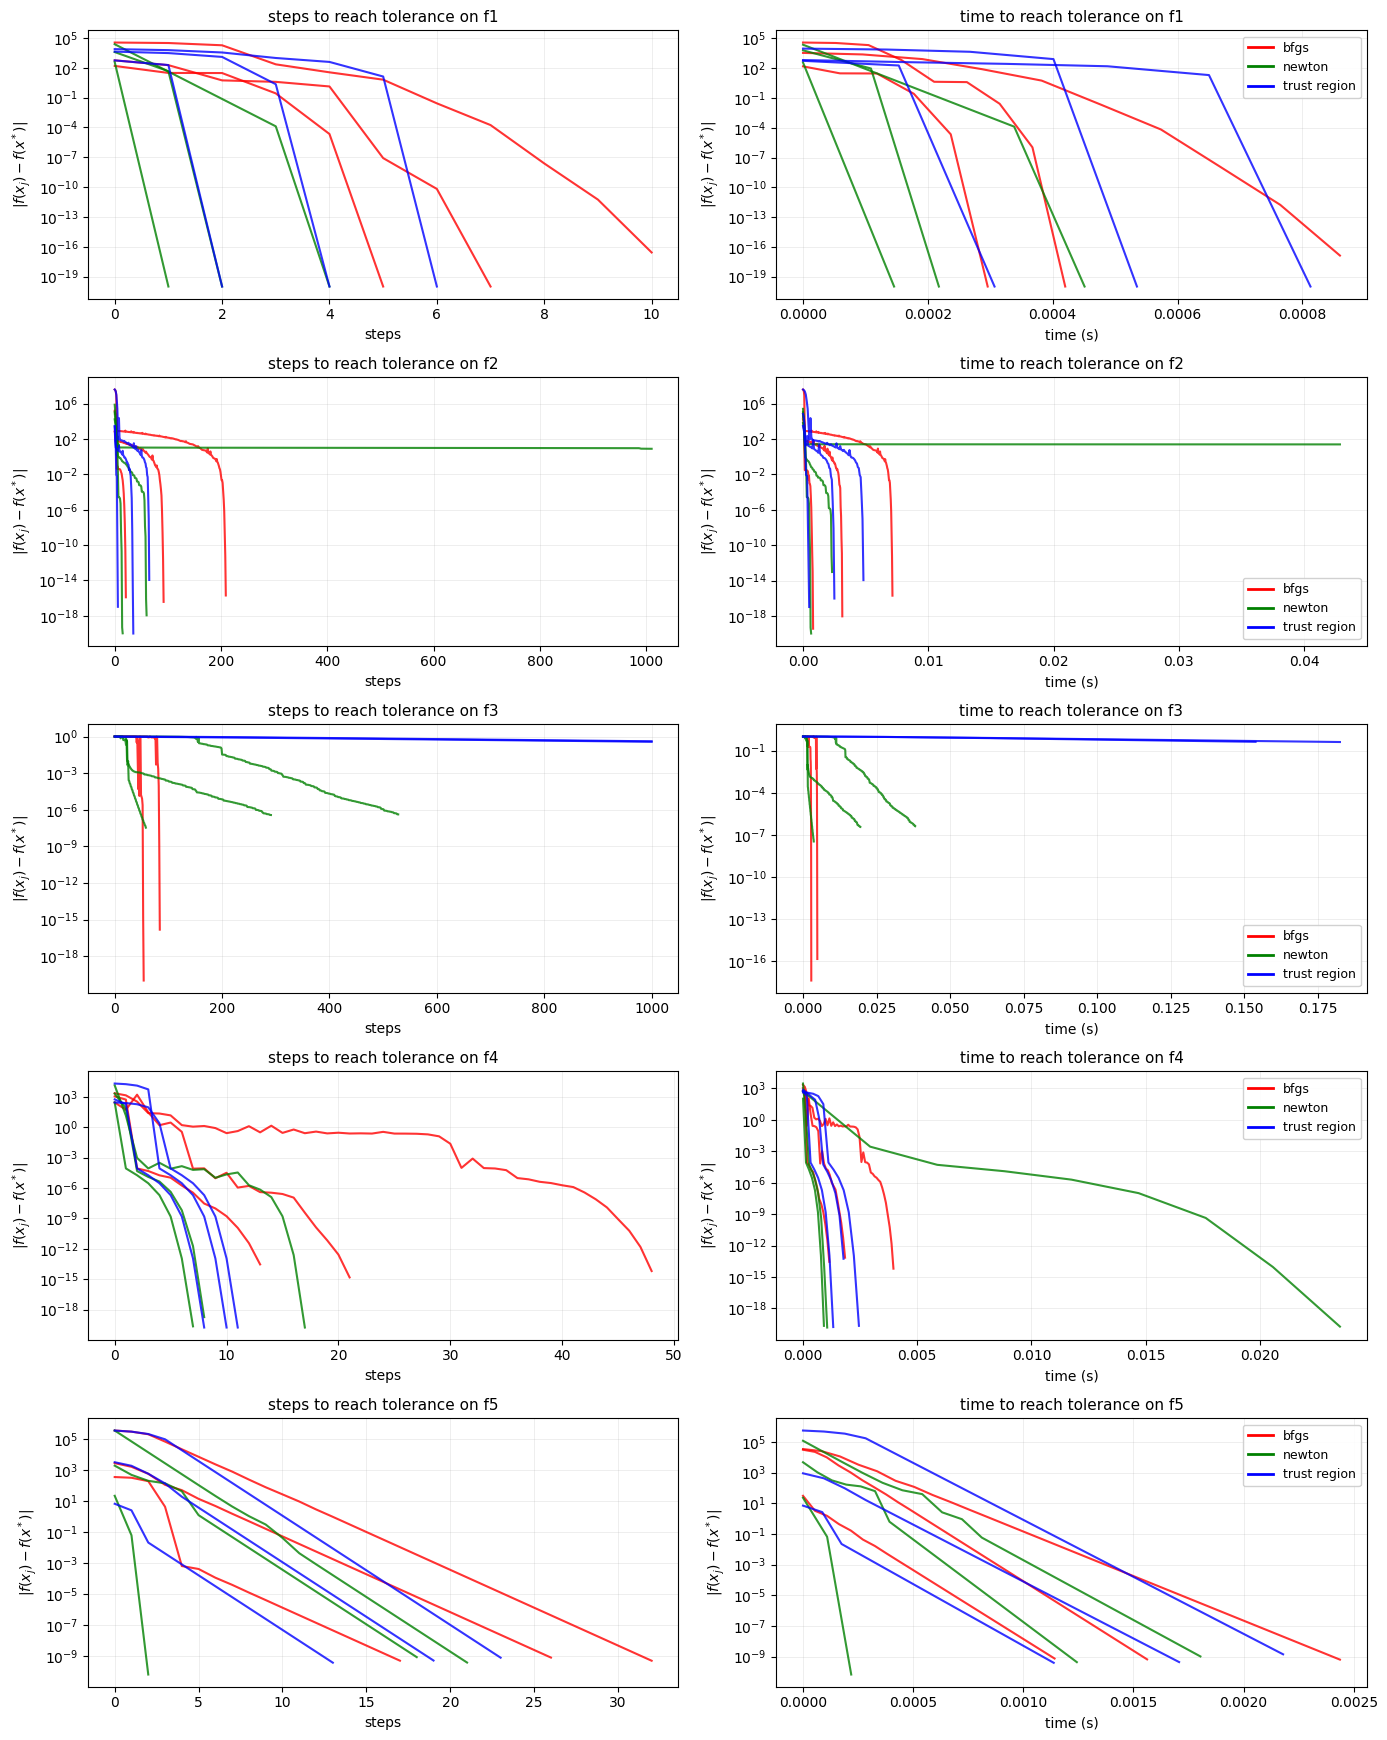

In [33]:
# Create convergence comparison plots
fig = plot_convergence_comparison(results, function_suite)
plt.show()